In [1]:
from Functions import *
import scipy.interpolate as interpolate
import winsound

### Load shapeError

In [2]:
def load_data(num):
    dir_profile = 'DXS_Xtals_FEA4WFS/'
    coords = np.loadtxt(dir_profile+'Nlist_%d.txt' %num, skiprows=12)
    data = np.loadtxt(dir_profile+'Uy_list_%d.txt' % num, skiprows=0)

    x = coords[:,1]
    y = coords[:,2]
    z = coords[:,3]
    dy = data[:,1]
    print(data.shape)
    # plt.figure()
    # plt.plot(x)
    # plt.figure()
    # plt.plot(z)

    xx = np.linspace(np.min(x), np.max(x), 1024)
    zz = np.linspace(np.min(z), np.max(z), 1024)
    xx,zz = np.meshgrid(xx,zz)

    # f = interpolate.interp2d(z,x,dy)
    dy2 = interpolate.griddata((x,z),dy,(xx,zz), fill_value=0)

    dy_symmetrize = np.concatenate((dy2,np.flipud(dy2)),axis=0)
    dy_symmetrize = np.concatenate((dy_symmetrize,np.fliplr(dy_symmetrize)),axis=1)

    xx2 = np.linspace(np.min(x), -np.min(x), 2048)
    zz2 = np.linspace(np.min(z), -np.min(z), 2048)
    xx2,zz2 = np.meshgrid(xx2,zz2)
    
    return dy_symmetrize, xx2, zz2

def plot_data(num, dy, xx, zz):
    plt.figure(figsize=(7 ,6))
    ax_im = plt.subplot2grid((6,7), (1,0), colspan=5, rowspan=3)
    ax_x = plt.subplot2grid((6,7), (4,0), colspan=5, rowspan=2)
    ax_y = plt.subplot2grid((6,7), (1,5), colspan=2, rowspan=3)
    ax_colorbar = plt.subplot2grid((6,7), (4,5), colspan=1, rowspan=2)
    im_profile = ax_im.imshow(dy*1e6+125, extent=(-7.5,7.5,-.75,.75),aspect=(20/4))
    ax_im.set_xlabel('Tangential coordinates (mm)')
    ax_im.set_ylabel('Sagittal coordinates (mm)')
    ax_x.plot(xx[0,:],dy[1024,:]*1e6+125)
    ax_x.set_ylabel('Height (nm)')
    ax_x.grid()
    ax_y.plot(dy[:,1024]*1e6+125,zz[:,0])
    ax_y.set_xlabel('Height (nm)')
    ax_y.grid()
    plt.colorbar(im_profile, cax=ax_colorbar, label='Height error (nm)')
    ax_im.set_title('Case %d' % num)


(5637, 2)
(4517, 2)
(4517, 2)
(5637, 2)
(1157, 2)
(1157, 2)


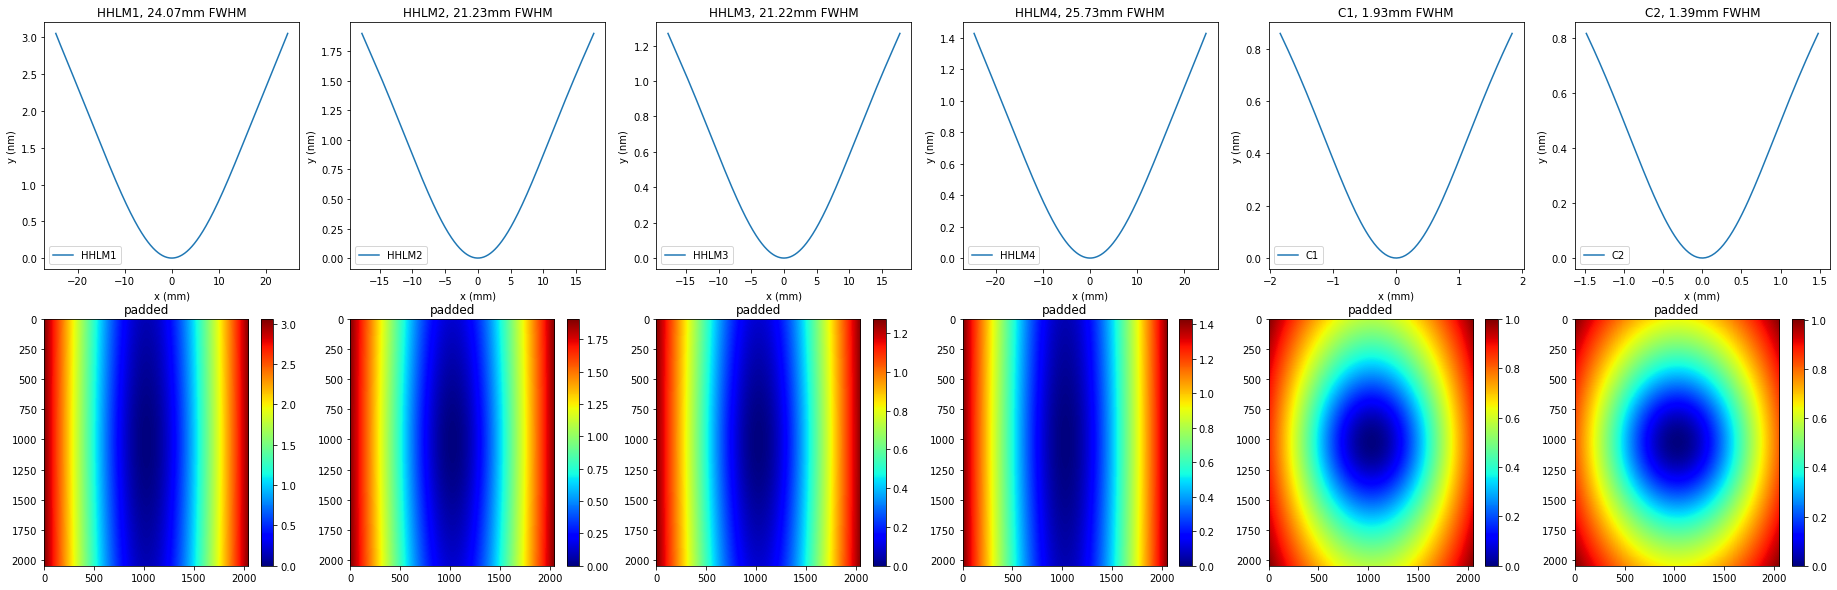

In [3]:
##### Load crystal shapeError
crystals = np.array(['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2'])    # list of crystals
n_crys = len(crystals)

# crystal_powers = [35, 25, 3, 3, 3, 3]
crystal_powers = [20, 15, 10, 10, 10, 10]

shapeErrors = [None for i in range(n_crys)]
x_mirs      = [None for i in range(n_crys)]
y_mirs      = [None for i in range(n_crys)]

# HRM crystal lengths (long) and widths (short)
l_crystal = [0.049240000000000006, 0.03546, 0.03546, 0.049240000000000006, 0.00368, 0.00296]
w_crystal = [0.001985351760528, 0.001985351760528, 0.001985351760528, 0.001985351760528, 0.001985351760528, 0.001985351760528]

crystal_profile_powers = np.array([
    [73.15, 16.53, 0.029, 0.027, 0.026, 0.03],
    [73.15, 16.79, 0.015, 0.015, 0.014, 0.013],
    [4.51, 50.1, 1.78, 1.69, 1.61, 1.88]
])

ratio_power = crystal_profile_powers/np.stack([crystal_powers for i in range(3)])

for i in range(3):
    for j in range(n_crys):
        if ratio_power[i,j] <=1:
            ratio_power[i,j] = 1/ratio_power[i,j]

# pick the most similar case to scale up/down for each crystal
options = []
for i in range(n_crys):
    options.append(ratio_power[:,0].argmin()+1)


# loading
for i, crystal in enumerate(crystals):
    crystal_height_factor = crystal_powers[i] / crystal_profile_powers[options[i]-1, i]    
    
    num = (options[i]-1)*n_crys + i+1
    dy, xx, zz = load_data(num)
    shapeErrors[i] = dy * 1e6 * crystal_height_factor    # shapeErrors in [nm]
    x_mirs[i] = xx[0]    # x axis in [mm]
    y_mirs[i] = zz[:,0]    # y axis in [mm]

# padding
for i in range(n_crys):
    shape = shapeErrors[i]
    
    # crystal length, width and resolutions; crystals are made to have the same size as the shapeError profiles at the moment
    l_crystal[i] = (x_mirs[i].max() - x_mirs[i].min())*1e-3; dx = (x_mirs[i][1]-x_mirs[i][0])*1e-3
    w_crystal[i] = (y_mirs[i].max() - y_mirs[i].min())*1e-3; dy = (y_mirs[i][1]-y_mirs[i][0])*1e-3
    
    # padded dimension
    size_x_padded = np.int(l_crystal[i]/dx) + 1; size_x_padded = size_x_padded + size_x_padded%2
    size_y_padded = np.int(w_crystal[i]/dy) + 1; size_y_padded = size_y_padded + size_y_padded%2

    # padding the out-skirt with maximum heights
    shapeError_new = np.ones((size_x_padded, size_y_padded)) * shape.max()
    roi_x_i = int((size_x_padded - shape.shape[0])/2)
    roi_x_f = roi_x_i + shape.shape[0]
    roi_y_i = int((size_y_padded - shape.shape[1])/2)
    roi_y_f = roi_y_i + shape.shape[1]

    shapeError_new[roi_x_i:roi_x_f, roi_y_i:roi_y_f] = shape.T
    shapeErrors[i] = shapeError_new.T

##### plots
x_FWHMs = [14456.77e-6, 14459.84e-6, 14452.53e-6, 1312.47e-6, 1317.63e-6, 321.91e-6]    # beam size at the output of each crystal
y_FWHMs = [706.86e-6, 707.26e-6, 707.94e-6, 708.32e-6, 718.2e-6, 719.41e-6]    # beam size at the output of each crystal
beta0s = [0.6441930561063302, 0.7492421541043375, 0.7492421541043375, 0.05102436691260805, 0.7492421541043375, 0.23448464050278972]    # output angle
projected_x_FWHMs = np.divide(x_FWHMs, np.sin(beta0s))    # beam FWHMs projected on crystal surface

plt.figure(figsize=(int(5*n_crys)+2, 10))
for i in range(n_crys):
    plt.subplot(2,n_crys, int(i+1))
    plt.plot(x_mirs[i], shapeErrors[i][1024,:], label=crystals[i])
    plt.legend()
    plt.xlabel('x (mm)')
    plt.ylabel('y (nm)')
    plt.title('{}, {}mm FWHM'.format(crystals[i], round(projected_x_FWHMs[i]*1e3,2)))
    plt.subplot(2,n_crys, n_crys+(int(i+1)))
    plt.imshow(shapeErrors[i], cmap='jet')
    plt.colorbar()
    plt.title('padded')
    plt.axis('tight')


### Setting up beam parameters

In [4]:
''' Beam parameters '''
N = 1024			# number of sampling points
E0 = 9481			# photon energy [eV]
tau = 400			# pulse duration [fs]
window = 50000		# total simulation time window [fs]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
	'photonEnergy': E0,
	'N': N,
	'sigma_x': 23e-6,
	'sigma_y': 23e-6,
	'rangeFactor': 5,
	'scaleFactor': 10,
	'z_source': 650-26
}

In [5]:
##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)
dir_case = dir_ev + 'scans/'; make_dir(dir_case)

print('\nCWD:',dir_case)

path exists
path exists
path exists

CWD: output/9481eV/scans/


In [6]:
def define_beamline(
    E0, slit_width, m2_p=175.16666666666669, shapeErrors=[None for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=256)
    
    ## Telescope
    m1 = optics.CurvedMirror('M1',p=185,q=-58,length=1,z=185+z_s,alpha=2.65e-3)
    im_after_T1 = optics.PPM('im_after_T1', z=m1.z+.01, FOV=5e-3, N=256)
    
    m2 = optics.CurvedMirror('M2',p=m2_p,q=1e5,length=1,z=300+z_s,alpha=2.65e-3,orientation=2)
    im_after_T2 = optics.PPM('im_after_T2', z=m2.z+.01, FOV=5e-3, N=256)
    
    ## HHLM
    asym = np.deg2rad(17)
    hhlm1 = optics.Crystal('HHLM1', hkl=[2,2,0], length=l_crystal[0], width=w_crystal[0], z=305+z_s, alphaAsym=-asym, E0=E0, 
                           orientation=0, pol='s', shapeError=shapeErrors[0])
    im_after_HHLM1 = optics.PPM('im_after_HHLM1', FOV=30e-3,N=256,z=hhlm1.z+.01)
    
    hhlm2 = optics.Crystal('HHLM2', hkl=[4,4,0], length=l_crystal[1], width=w_crystal[1], z=hhlm1.z+139e-3, E0=E0,
                           orientation=2, pol='s', shapeError=shapeErrors[1])
    im_after_HHLM2 = optics.PPM('im_after_HHLM2', FOV=30e-3,N=256,z=hhlm2.z+.01)
    
    hhlm3 = optics.Crystal('HHLM3', hkl=[4,4,0], length=l_crystal[2], width=w_crystal[2], z=hhlm1.z+361e-3, E0=E0,
                           orientation=0, pol='s', shapeError=shapeErrors[2])
    im_after_HHLM3 = optics.PPM('im_after_HHLM3', FOV=30e-3,N=256,z=hhlm3.z+.01)
    
    hhlm4 = optics.Crystal('HHLM4', hkl=[2,2,0], length=l_crystal[3], width=w_crystal[3], z=hhlm1.z+.5, alphaAsym=asym, E0=E0,
                           orientation=2, pol='s', shapeError=shapeErrors[3])
    im_after_HHLM4 = optics.PPM('im_after_HHLM4', FOV=30e-3,N=256,z=hhlm4.z+.01)
    
    ## HRM
    alphaAsym = np.deg2rad(29.5)    # crystal asymmetry angle
    hkl = [4,4,0]    # crystal plane
    f1 = 10.    # crystal-lens/mirror distance
    f2 = 10.    # lens/mirror focal distance
    
    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('C1', hkl=hkl, length=l_crystal[4], width=w_crystal[4], z=z_s+310, E0=E0, alphaAsym=0, 
                              orientation=0, pol='s', delta=0.e-6, shapeError=shapeErrors[4])
    im_after_C1 = optics.PPM('im_after_C1', z=crystal1.z+.01, FOV=5e-3, N=256)

    # second crystal: asymmetric reflection, orientation flipped relative to crystal1
    crystal2 = optics.Crystal('C2', hkl=hkl, length=l_crystal[5], width=w_crystal[5], z=crystal1.z+.05, E0=E0,alphaAsym=alphaAsym, 
                              orientation=2, pol='s', delta=0e-6, shapeError=shapeErrors[5])

    im_after_C2 = optics.PPM('im_after_C2', z=crystal2.z+.01, FOV=5e-3, N=256)
    
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    # elliptical mirror with ~10 meter focal length
    im_before_MIR1 = optics.PPM('im_before_MIR1', z=crystal2.z + f1 - .1, FOV=2e-3, N=256)
    mir1 = optics.CurvedMirror('mir1', z=crystal2.z+f1, p=1e5, q=f2, length=1.0, width=5e-3, alpha=3e-3, orientation=0)
    im_after_MIR1 = optics.PPM('im_after_MIR1', z=mir1.z+.1, FOV=5e-3, N=256)

    # slit at focus
    slit = optics.Slit('Slit', z=mir1.z+f2, x_width=slit_width, y_width=2e-3)
    print('slit width: {} um'.format(slit.x_width*1e6))

    # viewing point at focus
    im_focus = optics.PPM('im_focus', z=mir1.z+f2 + 1e-3, FOV=1e-3, N=1024)

    # elliptical mirror with ~10 meter focal length, for collimation
    im_before_MIR2 = optics.PPM('im_before_MIR2', z=mir1.z+2*f2 -.1, FOV=2e-3, N=256)
    mir2 = optics.CurvedMirror('mir2', z=mir1.z+2*f2, p=f2, q=1e5, length=1.0, width=5e-3, alpha=3e-3, orientation=2)
    im_after_MIR2 = optics.PPM('im_after_MIR2', z=mir2.z+.1, FOV=2e-3, N=256)
    
    # third crystal, symmetric reflection, same orientation as crystal2
    crystal3 = optics.Crystal('C3', hkl=hkl, length=10e-2, width=10e-3, z=mir2.z+f1, E0=E0,alphaAsym=-alphaAsym,
                              orientation=2, pol='s')
    im_after_C3 = optics.PPM('im_after_C3', z=crystal3.z+.01, FOV=5e-3, N=256)

    # fourth crystal, asymmetric reflection, same orientation as crystal1
    crystal4 = optics.Crystal('C4', hkl=hkl, length=10e-2, width=10e-3, z=crystal3.z+.05, E0=E0,alphaAsym=0, 
                              orientation=0, pol='s')
    im_out = optics.PPM('im_out', z=crystal4.z+.1, FOV=5e-3, N=256)

    # list of devices to propagate through
    telescope_devices = [im_input, m1, im_after_T1, m2, im_after_T2]
    HHLM_devices = [hhlm1, im_after_HHLM1, hhlm2, im_after_HHLM2, hhlm3, im_after_HHLM3, hhlm4, im_after_HHLM4]
    HRM_devices = [crystal1,im_after_C1, crystal2,im_after_C2, im_before_MIR1,mir1,im_after_MIR1, slit,im_focus,
               im_before_MIR2,mir2,im_after_MIR2, crystal3,im_after_C3, crystal4,im_out]
    
    all_devices = telescope_devices + HHLM_devices + HRM_devices
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return mono_beamline

### Calculate slit width

In [7]:
%%capture capt
##### perfect case
m2_p = 175.16666666666669
mono_beamline = define_beamline(E0,200e-6, m2_p = m2_p)

''' propagate '''
b1 = beam.Beam(beam_params=beam_params)
b2 = mono_beamline.propagate_beamline(b1)


In [8]:
def calc_slit_width(inbeam, lmbd, foc):
    # inbeam is the beamsize (2x FWHM) after Crystal 2
    # lmbd is wavelength of photon
    # asym is asymmetry angle of Crystal 2
    # foc is Mir1/Lens1 focal distance
    # returns mono focus size in [m] at the Fourier plane
    slt = 2*np.log(2)*lmbd*foc/np.pi/inbeam
    return 2.11 * slt    # 2x FWHM with some error (~factor of 5%)

wx = mono_beamline.im_after_C2.beam_analysis(mono_beamline.im_after_C2.get_profile_x(), mono_beamline.im_after_C2.get_profile_y())[2]
slit_width = calc_slit_width(wx*2, b2.lambda0, mono_beamline.mir1.q)

print('slit width: {}um\n'.format(round(slit_width*1e6,2)))

slit width: 1.9um



### Loop for collimation correction

In [9]:
##### general looping parameters
n_loop = 13
m2_p = np.linspace(150, 200, n_loop)


In [10]:
%%capture capt

##### looping parameters with shapeErrors

fails = []
for i in range(n_crys):
    # calculate the correct shapeError based on the simulation options
    crystal_name = crystals[i]
    crystal_error = [None for i in range(n_crys)]
    crystal_error[i] = shapeErrors[i]
    
    fname_crystal = '{}_{}W'.format(crystal_name, round(crystal_powers[i],3))
    print(dir_case+fname_crystal+'.h5')
    pulse_duration1 = np.zeros_like(m2_p) + 1e30
    pulse_tilt1 = np.zeros_like(m2_p) + 1e30
    spatial_chirp1 = np.zeros_like(m2_p) + 1e30
    energy_bandwidth1 = np.zeros_like(m2_p) + 1e30
    throughput1 = np.zeros_like(m2_p) + 1e30

    for j in range(n_loop):
        mono_beamline = define_beamline(E0,slit_width,m2_p=m2_p[j], shapeErrors=crystal_error)
        screen_names = ['im_input','im_out']

        beam_params['photonEnergy'] = E0
        try:
            pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=100)
            pulse.propagate(beamline=mono_beamline,screen_names=screen_names)
        except:
            fails.append([i, j])
        
        try:
            c, pulse_duration1[j] = pulse.pulse_duration('im_out')
        except:
            pulse_duration1[j] = 1e30
        try:
            pulse_tilt1[j] = pulse.pulsefront_tilt('im_out')
        except:
            pulse_tilt1[j] = 1e30
        try:
            spatial_chirp1[j] = pulse.spatial_chirp('im_out')
        except:
            spatial_chirp1[j] = 1e30
        try:
            energy_bandwidth1[j] = pulse.pulse_bandwidth('im_out')
        except:
            energy_bandwidth1[j] = 1e30
        try:
            throughput1[j] = pulse.throughput('im_input','im_out')
        except:
            throughput1[j] = 0.0
        
    with h5py.File(dir_case+fname_crystal+'.h5', 'w') as f:
        f.create_dataset('m2_p', data=m2_p)
        f.create_dataset('pulse_duration', data=pulse_duration1)
        f.create_dataset('tilt', data=pulse_tilt1)
        f.create_dataset('chirp', data=spatial_chirp1)
        f.create_dataset('bandwidth', data=energy_bandwidth1)
        f.create_dataset('throughput', data=throughput1)


In [11]:
import winsound
winsound.Beep(1500, 3000)